In [5]:
from google.colab import drive

drive.mount('/content/gdrive',force_remount=True)
  

Mounted at /content/gdrive


In [0]:
import pandas as pd
import urllib.request as req
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

In [0]:
sk_data=[]
day=[]
cond1={"class":"tah p10 gray03"}
cond2={"class":"tah p11"}

for i in range(400):
    url="https://finance.naver.com/item/sise_day.nhn?code=000660&page="+str(i+1)
    res=req.urlopen(url)
    soup=BeautifulSoup(res,"html.parser")

    a1=soup.find_all("span",cond1)
    a2=soup.find_all("span",cond2)
    for t in a1:
        day.append(int(t.string.replace('.','')))
    for t in a2:
        if t.string!='0':
            sk_data.append(int(t.string.replace(',','')))

sk_data=np.hstack([np.array(day).reshape(-1,1),np.array(sk_data).reshape(-1,5)])

In [0]:
df=pd.DataFrame(sk_data,columns=['date','close','open','high','low','volumn'])
df.to_csv("sk_hynix.csv",header=True,index=False)

In [2]:
df=pd.read_csv("/content/gdrive/My Drive/dataset/sk_hynix.csv")
df.drop("date",axis=1,inplace=True)
df.tail()

,close,open,high,low,volumn
3995,6160,6320,6560,5910,40876521
3996,6320,5900,6750,5730,64117923
3997,5950,5330,5950,5330,55326942
3998,5180,5800,5960,5180,43046920
3999,6090,5900,6420,5650,56158263


W0815 09:30:39.301981 140038463944576 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

W0815 09:30:39.303833 140038463944576 deprecation.py:323] From <ipython-input-3-cf4cc3a0f498>:28: BasicLSTMCell.__init__ (from tensorflow.python.ops.rnn_cell_impl) is deprecated and will be removed in a future version.
Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
W0815 09:30:39.305305 140038463944576 deprecation.py:323] From <ipython-input-3-cf4cc3a0f498>:29: dynamic_rnn (from tensorflow.python.ops.rnn) is deprecated and will be removed in a future version.
Instructions for updating:
Pleas

0 373.4532
1 82.168976
2 144.59853
3 50.565556
4 11.376474
5 16.876064
6 33.17676
7 43.82057
8 44.796883
9 38.040092
10 27.518276
11 17.20501
12 10.06979
13 7.524134
14 9.161433
15 12.970508
16 16.241419
17 16.921707
18 14.601288
19 10.448871
20 6.288852
21 3.5774498
22 2.848202
23 3.7175403
24 5.2483745
25 6.4268246
26 6.5710135
27 5.5586343
28 3.8200724
29 2.1099298
30 1.1399889
31 1.2192318
32 2.0827365
33 3.0465646
34 3.4415421
35 3.0390682
36 2.1460013
37 1.3205568
38 0.9712083
39 1.1370676
40 1.546247
41 1.8437984
42 1.8134612
43 1.4723743
44 1.0175945
45 0.68340206
46 0.60090345
47 0.73635
48 0.9347801
49 1.0324945
50 0.9602014
51 0.77046645
52 0.5822232
53 0.4930117
54 0.5217296
55 0.61154705
56 0.67862046
57 0.6682204
58 0.5837228
59 0.47572103
60 0.4032666
61 0.39435226
62 0.43118465
63 0.46822855
64 0.46785322
65 0.42622453
66 0.3711965
67 0.33708036
68 0.33835992
69 0.36213335
70 0.38190496
71 0.37914798
72 0.35559887
73 0.32864705
74 0.3156587
75 0.32058218
76 0.33288383
7

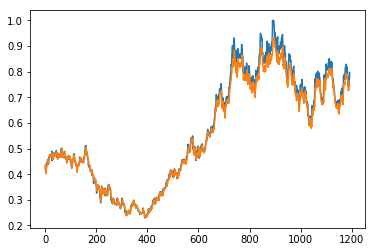

In [3]:
def MinMaxScaler(data):
    numerator=data-np.min(data,0)
    denominator=np.max(data,0)-np.min(data,0)
    return numerator/(denominator + 1e-7)

timesteps=7
input_dim=5
output_dim=1

xy=np.array(df)[::-1]
xy=MinMaxScaler(xy)

dataX=[]
dataY=[]
for i in range(len(xy)-timesteps):
    dataX.append(xy[i:i+timesteps])
    dataY.append(xy[i+timesteps,[0]])

train_num=int(len(xy)*0.7)
train_x=np.array(dataX[:train_num])
train_y=np.array(dataY[:train_num])
test_x=np.array(dataX[train_num:])
test_y=np.array(dataY[train_num:])

X=tf.placeholder(tf.float32,shape=[None,timesteps,input_dim])
Y=tf.placeholder(tf.float32,[None,output_dim])

cell=tf.contrib.rnn.BasicLSTMCell(num_units=7,state_is_tuple=True)
outputs,_states=tf.nn.dynamic_rnn(cell,X,dtype=tf.float32)
Y_pred=tf.contrib.layers.fully_connected(outputs[:,-1],output_dim,activation_fn=None)

loss=tf.reduce_sum(tf.square(Y_pred-Y))
optimizer=tf.train.AdamOptimizer(0.05).minimize(loss)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(1000):
        _,l=sess.run([optimizer,loss],feed_dict={X:train_x,Y:train_y})
        print(i,l)
    testPredict=sess.run(Y_pred,feed_dict={X:test_x})
plt.plot(test_y)
plt.plot(testPredict)
plt.show()

In [0]:
#예측치를 normalization하기 전으로 돌린다

xy1=np.array(df)[::-1]
testPredict=testPredict.reshape(-1)
numerator=xy1-np.min(xy1,0)
denominator=np.max(xy1,0)-np.min(xy1,0)
xy[2807:,0]=testPredict
xy2=xy*(denominator+1e-7)+np.min(xy1)

In [9]:
#예측치와 실제치를 비교했다.
print("predict: ",xy2[-5:,0],"\treal: ",xy1[-5:,0])

predict:  [71194.94798906 70981.37611396 71359.31515939 72341.20886929
 72353.38361748] 	real:  [72300 73300 74500 74500 76900]
